--------------------------------
#### Collocations and Bigrams
--------------------------

A collocation is a sequence of words that occur together unusually often. Thus __red wine__ is a collocation, whereas __the wine__ is not. 

A characteristic of collocations is that they are resistant to substitution with words that have similar senses; for example, __maroon wine__ sounds definitely odd.

To get a handle on collocations, we start off by extracting from a text a list of word pairs, also known as __bigrams__. 

> `collocations` are essentially just `frequent bigrams` 

    - frequent -> useful

#### Data : hotel reviews ... https://www.kaggle.com/datafiniti/hotel-reviews/data

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import spacy
import string


In [2]:
location = r'D:\AI-DATASETS\02-MISC-large\Datafiniti_Hotel_Reviews.csv'

In [3]:
reviews = pd.read_csv(location)

In [4]:
reviews.sample(5)

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
4566,AVweUb3O_7pvs4fzB8oA,2015-10-20T00:54:43Z,2018-04-17T10:16:56Z,810 S US Highway 1,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Jupiter,US,us/fl/jupiter/810sushighway1/1433548600,26.926880,...,2016-05-12T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g3433...,This hotel staff goes out of their way to make...,Quality staff and treatment,utica,mi,Denise A,https://www.yellowpages.com/jupiter-fl/mip/bes...,https://www.bestwestern.com/en_US/book/hotel-d...
840,AV-TGwK3IxWefVJwr5IJ,2017-11-06T20:51:11Z,2018-09-04T21:27:39Z,20 West Kinzie Street,"Hotels,Hotel",Accommodation & Food Services,Chicago,US,us/il/chicago/20westkinziestreet/153270062,41.889408,...,2018-03-27T00:00:00Z,4.4,https://www.booking.com/reviews/us/hotel/amalf...,Bad: The breakfast was just some muffins and w...,If you are looking for a comfortable place to ...,NaN,NaN,James,https://www.booking.com/reviews/us/hotel/amalf...,http://www.kinziehotel.com/
2215,AVwdMsswkufWRAb53Vy0,2017-04-10T07:43:42Z,2018-06-29T19:35:18Z,3730 Las Vegas Blvd S,"Hotels,Casinos,Resorts,Resort,Casino,Hotel",Accommodation & Food Services,Las Vegas,US,us/nv/lasvegas/3730lasvegasblvds/-1699935985,36.107741,...,"2016-07-12T00:00:00Z,2016-07-27T00:00:00Z,2016...",5.0,https://www.tripadvisor.com/Hotel_Review-g4596...,This was my third time at Aria Resort and it d...,Great comtemporary hotel,Birmingham,NaN,mini1978,https://www.tripadvisor.com/Hotel_Review-g4596...,http://www.arialasvegas.com
1785,AV1eT4k_RxPSIh2RZ5gv,2017-07-20T04:44:17Z,2018-08-27T16:47:44Z,101 N Broad St,"Hotels,Hotels and motels,Bar and grill restaur...",Accommodation & Food Services,Philadelphia,US,us/pa/philadelphia/101nbroadst/1243750363,39.954650,...,2018-08-26T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g6079...,"Everything was great, staff is wonderful, Mish...",Our New Favorite Hotel In Phili,Brick,NaN,michmlot,https://www.tripadvisor.com/Hotel_Review-g6079...,http://www.aloftphiladelphiadowntown.com/?SWAQ...
1448,AVwctAJvkufWRAb5yHGn,2016-06-04T21:31:59Z,2018-08-27T16:55:23Z,1100 N Central Ave,"Hotels,Lodging,Hotels Motels,Motels,Hotel",Accommodation & Food Services,Phoenix,US,us/az/phoenix/1100ncentralave/857837242,33.460000,...,2018-08-26T00:00:00Z,3.0,https://www.tripadvisor.com/Hotel_Review-g3131...,As Christian I found this hotel inappropriate ...,Interesting boutique hotel,Lafayette,Louisiana,Delia V,https://www.tripadvisor.com/Hotel_Review-g3131...,http://www.foundrehotels.com


#### take only the text column

In [5]:
comments = reviews['reviews.text']

In [6]:
comments.dtype

dtype('O')

In [7]:
pd.set_option('max_colwidth', 200)

In [8]:
comments.sample(5)

55                                                                                                        I stayed here with some friends for a convention. It was a good room and the free breakfast was nice.
305     Bad: Room and bed were tiny - not even a queen bed. Bed took up most of the room. Breakfast was coffee and a bunch of cold bagels. Bathroom was also tiny. Not worth the exhorbitant price at all. G...
3784                                                                                                                                           Bad: Noise, small room, exposed nails in carpet. Good: Locations
7340                                                                                                                                     If u want an historic sight with all the amenities, this is your pkace
1243    This place is ideally located with theaters, supermarkets, fast food, fine restaurants, all near by. The architecture is really beautiful and it is brand new. I

#### 1. Preprocessing

In [9]:
# function to remove non-ascii characters
def removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

In [10]:
comments = comments.astype('str')

In [11]:
# remove non-ascii characters
comments = comments.map(lambda x: removeNonAscii(x))

In [12]:
# get stop words of all languages
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

In [13]:
# function to detect language based on # of stop words for particular language
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    
    lang  = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
    
    if lang == 'english':
        return True
    else:
        return False

In [15]:
# filter for only english comments
eng_comments = comments[comments.apply(get_language)]

In [20]:
pd.set_option('display.max_colwidth', -1)

C:\Users\bhupe\AppData\Local\Temp\ipykernel_30832\3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [21]:
eng_comments.head()

30    heat in room did not work properly, tv remote was broken excessive noise                                                                                
33    It was a great stay                                                                                                                                     
39    was too quick, but very nice area                                                                                                                       
44    Convenient and comfortable. Staff is great, breakfast and WiFi is a bonus.                                                                              
52    Our room was a bit small. There was no microwave in the room. Location was more for couples than for family. The room itself And service were excellent.
Name: reviews.text, dtype: object

In [22]:
#drop duplicates
eng_comments.drop_duplicates(inplace=True)

In [62]:
#!python -m spacy download en
#!python -m spacy download en_core_web_sm

In [23]:
#load spacy
nlp = spacy.load("en_core_web_sm")

In [24]:
# function to clean and lemmatize comments
def clean_comments(text):
    
    # remove punctuations
    regex   = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    
    nopunct = regex.sub(" ", str(text))
    
    # use spacy to lemmatize comments
    doc   = nlp(nopunct, disable=['parser','ner'])
    
    lemma = [token.lemma_ for token in doc]
    
    return lemma

In [25]:
%%time
# apply function to clean and lemmatize comments
lemmatized = eng_comments.map(clean_comments)

Wall time: 2.5 s


In [26]:
%%time
# make sure to lowercase everything
lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

Wall time: 2.21 ms


In [27]:
lemmatized.head(8)

30     [heat, in, room, do, not, work, properly,  , tv, remote, be, break, excessive, noise]                                                                                                        
33     [it, be, a, great, stay]                                                                                                                                                                     
39     [be, too, quick,  , but, very, nice, area]                                                                                                                                                   
44     [convenient, and, comfortable,  , staff, be, great,  , breakfast, and, wifi, be, a, bonus]                                                                                                   
52     [our, room, be, a, bit, small,  , there, be, no, microwave, in, the, room,  , location, be, more, for, couple, than, for, family,  , the, room, itself, and, service, be, excellent]         
53     [this, h

-------------------------------------------------
#### bigrams and trigrams
-------------------------------------------------

In [28]:
type(lemmatized)

pandas.core.series.Series

In [29]:
pd.DataFrame(lemmatized)

,reviews.text
30,"[heat, in, room, do, not, work, properly, , tv, remote, be, break, excessive, noise]"
33,"[it, be, a, great, stay]"
39,"[be, too, quick, , but, very, nice, area]"
44,"[convenient, and, comfortable, , staff, be, great, , breakfast, and, wifi, be, a, bonus]"
52,"[our, room, be, a, bit, small, , there, be, no, microwave, in, the, room, , location, be, more, for, couple, than, for, family, , the, room, itself, and, service, be, excellent]"
...,...
9836,"[not, luxury, , but, not, dirty, and, a, place, to, rest, head, , can, t, complain, , great, price, for, a, room]"
9902,"[the, room, be, very, clean, and, the, staff, at, the, front, desk, be, wonderful, helpful, , nice, to, have, a, hot, breakfast, option, too]"
9920,"[it, be, great, for, the, night, , very, nice, and, very, quiet, , very, helpful, person, at, front, desk]"
9939,"[a, stop, for, lunch, be, fine, ]"


In [30]:
# turn all comments' tokens into one single list
unlist_comments = [item for items in lemmatized for item in items]

In [31]:
len(unlist_comments)

10233

In [32]:
unlist_comments[:30]

['heat',
 'in',
 'room',
 'do',
 'not',
 'work',
 'properly',
 ' ',
 'tv',
 'remote',
 'be',
 'break',
 'excessive',
 'noise',
 'it',
 'be',
 'a',
 'great',
 'stay',
 'be',
 'too',
 'quick',
 ' ',
 'but',
 'very',
 'nice',
 'area',
 'convenient',
 'and',
 'comfortable']

#### 2. FINDERS - Initialize NLTK's Bigrams/Trigrams Finder

#### `nltk.BigramCollocationFinder`

A tool for the finding and ranking of bigram collocations or other association measures. It is often useful to use from_words() rather than constructing an instance directly.

The collocations package provides collocation finders which by default consider all ngrams in a text as candidate collocations:

Finders - example

In [33]:
text = "I do not like green eggs and ham, I do not like them Sam I am!"
tokens = nltk.wordpunct_tokenize(text)

tokens

['I',
 'do',
 'not',
 'like',
 'green',
 'eggs',
 'and',
 'ham',
 ',',
 'I',
 'do',
 'not',
 'like',
 'them',
 'Sam',
 'I',
 'am',
 '!']

In [34]:
finder     = nltk.collocations.BigramCollocationFinder.from_words(tokens)

items_dict = finder.ngram_fd.items()

In [35]:
type(finder)

nltk.collocations.BigramCollocationFinder

In [36]:
len(items_dict)

14

In [37]:
items_dict

dict_items([(('I', 'do'), 2), (('do', 'not'), 2), (('not', 'like'), 2), (('like', 'green'), 1), (('green', 'eggs'), 1), (('eggs', 'and'), 1), (('and', 'ham'), 1), (('ham', ','), 1), ((',', 'I'), 1), (('like', 'them'), 1), (('them', 'Sam'), 1), (('Sam', 'I'), 1), (('I', 'am'), 1), (('am', '!'), 1)])

In [38]:
bigram_measures  = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [39]:
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored

[(('I', 'do'), 0.1111111111111111),
 (('do', 'not'), 0.1111111111111111),
 (('not', 'like'), 0.1111111111111111),
 ((',', 'I'), 0.05555555555555555),
 (('I', 'am'), 0.05555555555555555),
 (('Sam', 'I'), 0.05555555555555555),
 (('am', '!'), 0.05555555555555555),
 (('and', 'ham'), 0.05555555555555555),
 (('eggs', 'and'), 0.05555555555555555),
 (('green', 'eggs'), 0.05555555555555555),
 (('ham', ','), 0.05555555555555555),
 (('like', 'green'), 0.05555555555555555),
 (('like', 'them'), 0.05555555555555555),
 (('them', 'Sam'), 0.05555555555555555)]

In [40]:
sorted(bigram for bigram, score in scored)

[(',', 'I'),
 ('I', 'am'),
 ('I', 'do'),
 ('Sam', 'I'),
 ('am', '!'),
 ('and', 'ham'),
 ('do', 'not'),
 ('eggs', 'and'),
 ('green', 'eggs'),
 ('ham', ','),
 ('like', 'green'),
 ('like', 'them'),
 ('not', 'like'),
 ('them', 'Sam')]

... back to the main code

In [41]:
%%time
bigramFinder  = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_comments)

Wall time: 65.8 ms


1. Counting Frequencies of Adjacent Words

    - Main idea: simply order by frequency

    - Issues: too sensitive to very frequent pairs and pronouns/articles/prepositions come up often

    - Solution: filter for only adjectives and nouns

#### bigrams

In [42]:
bigram_freq = bigramFinder.ngram_fd.items()

In [43]:
type(bigram_freq)

dict_items

In [44]:
len(bigram_freq)

5356

In [45]:
list(bigram_freq)[:15]

[(('heat', 'in'), 1),
 (('in', 'room'), 2),
 (('room', 'do'), 1),
 (('do', 'not'), 11),
 (('not', 'work'), 3),
 (('work', 'properly'), 2),
 (('properly', ' '), 2),
 ((' ', 'tv'), 4),
 (('tv', 'remote'), 1),
 (('remote', 'be'), 1),
 (('be', 'break'), 3),
 (('break', 'excessive'), 1),
 (('excessive', 'noise'), 1),
 (('noise', 'it'), 1),
 (('it', 'be'), 44)]

In [46]:
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

In [47]:
bigramFreqTable.head(10).reset_index(drop=True)

,bigram,freq
0,"( , the)",137
1,"(be, very)",110
2,"(staff, be)",84
3,"(room, be)",75
4,"(and, the)",63
5,"(be, a)",61
6,"(the, staff)",55
7,"(the, room)",51
8,"(the, hotel)",48
9,"(hotel, be)",47


In [48]:
bigramFreqTable.sample(10)

,bigram,freq
3387,"(nice, motel)",1
5241,"(at, be)",1
971,"(provide, shampoo)",1
1491,"(minor, flaw)",1
2903,"( , only)",1
4403,"(nice, location)",2
2191,"(of, which)",1
2928,"(call, in)",1
3247,"(staff, road)",1
3761,"(days, )",1


In [49]:
# get english stopwords
en_stopwords = set(stopwords.words('english'))

In [50]:
# function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' ' in ngram or 't' in ngram:
        return False
    
    for word in ngram:
        if word in en_stopwords:
            return False
        
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type      = ('NN', 'NNS', 'NNP', 'NNPS')
    
    tags = nltk.pos_tag(ngram)
    
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

[('Sukanya', 'NNP'), (',', ','), ('Rajib', 'NNP'), ('Naba', 'NNP'), ('good', 'JJ'), ('friends', 'NNS'), ('.', '.')]
[('Sukanya', 'NNP'), ('getting', 'VBG'), ('married', 'VBN'), ('next', 'JJ'), ('year', 'NN'), ('.', '.')]
[('Marriage', 'NN'), ('big', 'JJ'), ('step', 'NN'), ('one', 'CD'), ('’', 'NN'), ('life.\\', 'VBZ'), ('It', 'PRP'), ('exciting', 'VBG'), ('frightening', 'VBG'), ('.', '.')]
[('But', 'CC'), ('friendship', 'NN'), ('sacred', 'VBD'), ('bond', 'NN'), ('people', 'NNS'), ('.', '.')]
[('\\', 'VB'), ('It', 'PRP'), ('special', 'JJ'), ('kind', 'NN'), ('love', 'VB'), ('us', 'PRP'), ('.', '.')]
[('Many', 'JJ'), ('must', 'MD'), ('tried', 'VB'), ('searching', 'VBG'), ('friend', 'NN'), ('never', 'RB'), ('found', 'VBD'), ('right', 'JJ'), ('one', 'CD'), ('.', '.')]

In [51]:
%%time
# filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

Wall time: 971 ms


In [52]:
filtered_bi[:30]

,bigram,freq
105,"(friendly, staff)",27
95,"(great, location)",16
305,"(front, desk)",14
17,"(great, stay)",14
1042,"(great, place)",13
148,"(clean, room)",12
1139,"(nice, hotel)",10
99,"(comfortable, bed)",9
393,"(helpful, staff)",9
1656,"(great, breakfast)",8


#### Trigrams

In [53]:
trigram_freq = trigramFinder.ngram_fd.items()

In [54]:
len(trigram_freq)

8288

In [55]:
list(trigram_freq)[:10]

[(('heat', 'in', 'room'), 1),
 (('in', 'room', 'do'), 1),
 (('room', 'do', 'not'), 1),
 (('do', 'not', 'work'), 3),
 (('not', 'work', 'properly'), 2),
 (('work', 'properly', ' '), 2),
 (('properly', ' ', 'tv'), 1),
 ((' ', 'tv', 'remote'), 1),
 (('tv', 'remote', 'be'), 1),
 (('remote', 'be', 'break'), 1)]

In [56]:
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)

In [57]:
trigramFreqTable.head(10).reset_index(drop=True)

,trigram,freq
0,"(the, staff, be)",46
1,"(the, room, be)",39
2,"(staff, be, very)",29
3,"(the, hotel, be)",26
4,"( , the, staff)",25
5,"( , staff, be)",22
6,"( , it, be)",21
7,"( , the, room)",20
8,"(the, bed, be)",20
9,"(room, be, very)",19


-- bigrams
-- proverbs ??
-- idioms ??
-- removing ambiguities
-- river bank

In [58]:
trigramFreqTable.sample(10)

,trigram,freq
4497,"(a, thin, rug)",1
1025,"(town, for, 24)",1
7026,"(pm, as, check)",1
1694,"(for, our, madison)",1
4460,"(purpose, , room)",1
4441,"( , enjoy, my)",1
1444,"(importantly, it, be)",1
5599,"(make, an, error)",1
7190,"(coffee, , o)",1
5163,"(king, size, bed)",1


In [59]:
def rightTypesTri(ngram):
    
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    
    for word in ngram:
        if word in en_stopwords:
            return False
        
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    
    tags = nltk.pos_tag(ngram)
    
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [60]:
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]

In [61]:
filtered_tri[:10]

,trigram,freq
155,"(great, customer, service)",3
2903,"(front, desk, staff)",2
779,"(free, shuttle, service)",2
3937,"(clean, spacious, room)",2
5455,"(flat, screen, tv)",2
7048,"(ocean, face, room)",2
1908,"(nice, friendly, staff)",2
1343,"(room, smell, musty)",2
6150,"(great, staff, hotel)",1
6133,"(front, desk, clerk)",1


In [62]:
freq_bi  = filtered_bi[:20].bigram.values
freq_tri = filtered_tri[:20].trigram.values

In [63]:
freq_bi

array([('friendly', 'staff'), ('great', 'location'), ('front', 'desk'),
       ('great', 'stay'), ('great', 'place'), ('clean', 'room'),
       ('nice', 'hotel'), ('comfortable', 'bed'), ('helpful', 'staff'),
       ('great', 'breakfast'), ('great', 'hotel'), ('great', 'value'),
       ('great', 'time'), ('nice', 'room'), ('comfortable', 'room'),
       ('complimentary', 'breakfast'), ('hotel', 'staff'),
       ('great', 'room'), ('free', 'breakfast'), ('easy', 'access')],
      dtype=object)

In [64]:
freq_tri

array([('great', 'customer', 'service'), ('front', 'desk', 'staff'),
       ('free', 'shuttle', 'service'), ('clean', 'spacious', 'room'),
       ('flat', 'screen', 'tv'), ('ocean', 'face', 'room'),
       ('nice', 'friendly', 'staff'), ('room', 'smell', 'musty'),
       ('great', 'staff', 'hotel'), ('front', 'desk', 'clerk'),
       ('repairs', 'need', 'nice'), ('need', 'nice', 'place'),
       ('site', 'parking', 'check'), ('motel', 'highly', 'quiet'),
       ('low', 'price', 'compare'), ('cracker', 'pre', 'dinner'),
       ('offer', 'free', 'apple'),
       ('downtown', 'public', 'transportation'),
       ('time', 'downtown', 'public'), ('great', 'time', 'downtown')],
      dtype=object)

### 3. PMI - Pointwise Mutual Information

For bigrams

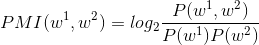

For trigrams

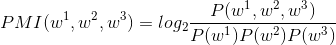

The main intuition is that it measures how much more likely the words co-occur than if they were independent. 

However, it is very sensitive to rare combination of words. 

For example, if a random bigram ‘abc xyz’ appears, and neither ‘abc’ nor ‘xyz’ appeared anywhere else in the text, ‘abc xyz’ will be identified as highly significant bigram when it could just be a random misspelling or a phrase too rare to generalize as a bigram. 

Therefore, this method is often used with a frequency filter.

In [65]:
bigram_measures  = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

Ex...

In [66]:
finder = nltk.collocations.BigramCollocationFinder.from_words(nltk.corpus.genesis.words('english-web.txt'))

In [67]:
finder.nbest(bigram_measures.pmi, 50) 

[('Allon', 'Bacuth'),
 ('Ashteroth', 'Karnaim'),
 ('Ben', 'Ammi'),
 ('En', 'Mishpat'),
 ('Jegar', 'Sahadutha'),
 ('Salt', 'Sea'),
 ('Whoever', 'sheds'),
 ('appoint', 'overseers'),
 ('aromatic', 'resin'),
 ('cutting', 'instrument'),
 ('direct', 'descendants'),
 ('droves', 'apart'),
 ('during', 'mating'),
 ('falls', 'backward'),
 ('fig', 'leaves'),
 ('flaming', 'torch'),
 ('fresh', 'poplar'),
 ('fully', 'pay'),
 ('fury', 'turns'),
 ('hearts', 'failed'),
 ('hot', 'springs'),
 ('interpretations', 'belong'),
 ('leaf', 'plucked'),
 ('months', 'later'),
 ('olive', 'leaf'),
 ('ravenous', 'wolf'),
 ('remaining', 'silent'),
 ('rider', 'falls'),
 ('royal', 'dainties'),
 ('sandal', 'strap'),
 ('seek', 'occasion'),
 ('sewed', 'fig'),
 ('solemnly', 'warned'),
 ('sweet', 'savor'),
 ('Baal', 'Hanan'),
 ('Bethlehem', ')."'),
 ('Kiriath', 'Arba'),
 ('Like', 'Nimrod'),
 ('Shaveh', 'Kiriathaim'),
 ('ancient', 'hills'),
 ('baked', 'unleavened'),
 ('binding', 'sheaves'),
 ('bitter', 'cry'),
 ('break', 'loos

While these words are highly collocated, the expressions are also very infrequent. herefore it is useful to apply filters, such as ignoring all bigrams which occur less than n times in the corpus:

In [68]:
bigramFinder.apply_freq_filter(20)

In [69]:
finder.nbest(bigram_measures.pmi, 10)

[('Allon', 'Bacuth'),
 ('Ashteroth', 'Karnaim'),
 ('Ben', 'Ammi'),
 ('En', 'Mishpat'),
 ('Jegar', 'Sahadutha'),
 ('Salt', 'Sea'),
 ('Whoever', 'sheds'),
 ('appoint', 'overseers'),
 ('aromatic', 'resin'),
 ('cutting', 'instrument')]

... back to the main code

In [70]:
bigramFinder.apply_freq_filter(20)

In [71]:
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigram_measures.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

In [72]:
bigramPMITable[:10]

,bigram,PMI
0,"(check, in)",5.855278
1,"(close, to)",5.266494
2,"(place, to)",4.804214
3,"(this, hotel)",4.649958
4,"(friendly, staff)",4.210482
5,"(i, have)",4.017617
6,"(have, a)",3.877998
7,"(very, comfortable)",3.779761
8,"(very, nice)",3.677186
9,"(very, clean)",3.511013


for trigrams 

In [73]:
trigramFinder.apply_freq_filter(20)

In [74]:
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigram_measures.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

In [75]:
trigramPMITable[:10]

,trigram,PMI
0,"(staff, be, very)",6.964406
1,"(the, bed, be)",6.936204
2,"(the, staff, be)",6.424142
3,"(the, room, be)",6.084103
4,"(the, hotel, be)",5.682448
5,"( , it, be)",5.294036
6,"( , the, staff)",4.940304
7,"( , staff, be)",4.573454
8,"( , the, room)",4.516497


In [76]:
pmi_bi  = bigramPMITable[:20].bigram.values
pmi_tri = trigramPMITable[:20].trigram.values

### 4. Hypothesis Testing

#### 4a. t-test:
Consider if we have a corpus with N words, and __social__ and __media__ have word counts C(social) and C(media) respectively. 

Assuming null hypothesis with social and media being independent:

$$ H_0: \text {'social media' occurs with probability}:  
 \sigma = p(social) * p(media) = \frac{C(social)}{N} * \frac{C(media)}{N}$$

$$ H_a : \text {'social media' does not occur with probability } \sigma$$


However, the same problem occurs where pairs with prepositions, pronouns, articles etc. come up as most significant. Therefore, we need to apply the same filters from 1.

In [112]:
bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigram_measures.student_t)), columns=['bigram','t']).sort_values(by='t', ascending=False)

In [113]:
bigramTtable.head()

,bigram,t
0,"( , -pron-)",71.185085
1,"( , the)",59.235948
2,"(-pron-, be)",54.243457
3,"( , more)",49.915807
4,"(be, very)",48.264385


In [114]:
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]

In [115]:
filteredT_bi[:10]

,bigram,t
25,"(front, desk)",30.635724
97,"(friendly, staff)",17.794989
99,"(great, location)",17.699336
103,"(walk, distance)",17.543390
175,"(free, breakfast)",13.800066
176,"(customer, service)",13.775283
193,"(continental, breakfast)",13.350849
202,"(desk, staff)",13.194821
219,"(comfortable, bed)",12.831863
235,"(next, door)",12.509709


trigrams ..

In [116]:
trigramTtable = pd.DataFrame(list(trigramFinder.score_ngrams(trigram_measures.student_t)), columns=['trigram','t']).sort_values(by='t', ascending=False)

In [117]:
trigramTtable.head()

,trigram,t
0,"( , -pron-, be)",46.630959
1,"(the, room, be)",39.865469
2,"( , the, room)",35.982368
3,"(the, staff, be)",32.644025
4,"( , -pron-, have)",31.156469


In [119]:
filteredT_tri = trigramTtable[trigramTtable.trigram.map(lambda x: rightTypesTri(x))]

In [120]:
filteredT_tri.head(10)

,trigram,t
134,"(front, desk, staff)",12.726861
877,"(non, smoking, room)",6.324501
946,"(front, desk, clerk)",6.164333
974,"(regis, new, york)",6.082761
1227,"(holiday, inn, express)",5.656853
1352,"(suites, anaheim, maingate)",5.477225
1417,"(hilton, garden, inn)",5.385163
1471,"(flat, screen, tv)",5.291502
1536,"(maingate, near, angel)",5.196152
1786,"(octavia, margineanhotel, manager)",4.898979


In [121]:
t_bi  = filteredT_bi[:20].bigram.values
t_tri = filteredT_tri[:20].trigram.values

Results are similar to the frequency count technique from 1.:


__T-test__ has been criticized as it assumes normal distribution. Therefore, we will also look into the __chi-square test__.

#### 4.b chi-square test

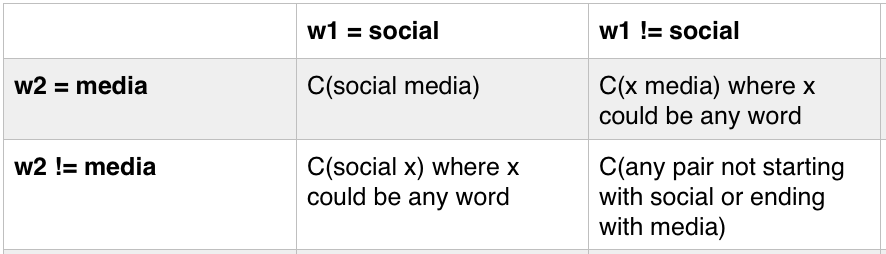

In [122]:
bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigram_measures.chi_sq)), columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)

In [123]:
bigramChiTable.head(20)

,bigram,chi-sq
0,"(honua, kai)",622565.484761
1,"(dixie, krauss)",602481.818058
2,"(wi, fi)",581387.084749
3,"(octavia, margineanhotel)",513078.193352
4,"(sarah, junge)",479904.310161
5,"(santa, monica)",441815.333132
6,"(front, desk)",398548.850501
7,"( , more)",358049.212633
8,"(french, quarter)",328903.509018
9,"(las, vegas)",311625.093298


In [124]:
trigramChiTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigram_measures.chi_sq)), columns=['trigram','chi-sq']).sort_values(by='chi-sq', ascending=False)

In [125]:
trigramChiTable.head(20)

,trigram,chi-sq
0,"(octavia, margineanhotel, manager)",9.019561e+08
1,"(suites, anaheim, maingate)",7.843127e+08
2,"(towneplace, suites, anaheim)",7.436453e+08
3,"(maingate, near, angel)",7.175558e+08
4,"(near, angel, stadium)",3.335081e+08
5,"(anaheim, maingate, near)",3.318720e+08
6,"(flat, screen, tv)",2.931878e+08
7,"(holiday, inn, express)",1.207276e+08
8,"(regis, new, york)",1.181343e+08
9,"(within, walk, distance)",1.004502e+08


In [126]:
chi_bi  = bigramChiTable[:20].bigram.values
chi_tri = trigramChiTable[:20].trigram.values

### 5. Likelihood

In [127]:
bigramLikTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigram_measures.likelihood_ratio)), columns=['bigram','likelihood ratio']).sort_values(by='likelihood ratio', ascending=False)

In [128]:
bigramLikTable.head()

,bigram,likelihood ratio
0,"( , more)",25296.925424
1,"( , -pron-)",12466.405901
2,"(front, desk)",11666.065410
3,"(be, very)",9569.426639
4,"(this, hotel)",8388.943058


In [135]:
filteredLik_bi = bigramLikTable[bigramLikTable.bigram.map(lambda x: rightTypes(x))]

In [136]:
filteredLik_bi.head(10)

,bigram,likelihood ratio
2,"(front, desk)",11666.065410
36,"(walk, distance)",3698.515035
78,"(customer, service)",2006.851211
90,"(continental, breakfast)",1840.679638
95,"(great, location)",1748.968721
97,"(hampton, inn)",1685.491348
98,"(friendly, staff)",1664.990646
113,"(next, door)",1450.548649
117,"(hot, tub)",1424.714472
130,"(free, breakfast)",1236.519922


In [137]:
trigramLikTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigram_measures.likelihood_ratio)), columns=['trigram','likelihood ratio']).sort_values(by='likelihood ratio', ascending=False)

In [138]:
trigramLikTable.head()

,trigram,likelihood ratio
0,"( , more, -pron-)",40713.011611
1,"( , more, this)",39398.742101
2,"(the, , more)",38216.809065
3,"( , more, the)",38070.532234
4,"( , more, great)",38067.043680


In [139]:
filteredLik_tri = trigramLikTable[trigramLikTable.trigram.map(lambda x: rightTypesTri(x))]

In [140]:
filteredLik_tri.head(20)

,trigram,likelihood ratio
191,"(front, desk, staff)",18855.469483
236,"(front, desk, clerk)",18642.747008
1511,"(restaurant, within, walk)",3067.992341
1537,"(hampton, inn, suites)",2981.740068
1672,"(regis, new, york)",2570.347514
1853,"(new, york, city)",2042.711403
1868,"(non, smoking, room)",2012.895181
1980,"(holiday, inn, express)",1778.090714
2048,"(flat, screen, tv)",1647.289357
2074,"(suites, anaheim, maingate)",1587.522148


In [141]:
lik_bi  = filteredLik_bi[:20].bigram.values
lik_tri = filteredLik_tri[:20].trigram.values

### Bigram Comparison

In [142]:
bigramsCompare = pd.DataFrame([freq_bi, pmi_bi, t_bi, chi_bi, lik_bi]).T

In [143]:
bigramsCompare.head()

,0,1,2,3,4
0,"(front, desk)","(sarah, junge)","(front, desk)","(honua, kai)","(front, desk)"
1,"(friendly, staff)","(santa, monica)","(friendly, staff)","(dixie, krauss)","(walk, distance)"
2,"(great, location)","(octavia, margineanhotel)","(great, location)","(wi, fi)","(customer, service)"
3,"(walk, distance)","(dixie, krauss)","(walk, distance)","(octavia, margineanhotel)","(continental, breakfast)"
4,"(clean, room)","(honua, kai)","(free, breakfast)","(sarah, junge)","(great, location)"


In [144]:
bigramsCompare.columns = ['Frequency With Filter', 'PMI', 'T-test With Filter', 'Chi-Sq Test', 'Likeihood Ratio Test With Filter']

In [145]:
bigramsCompare

,Frequency With Filter,PMI,T-test With Filter,Chi-Sq Test,Likeihood Ratio Test With Filter
0,"(front, desk)","(sarah, junge)","(front, desk)","(honua, kai)","(front, desk)"
1,"(friendly, staff)","(santa, monica)","(friendly, staff)","(dixie, krauss)","(walk, distance)"
2,"(great, location)","(octavia, margineanhotel)","(great, location)","(wi, fi)","(customer, service)"
3,"(walk, distance)","(dixie, krauss)","(walk, distance)","(octavia, margineanhotel)","(continental, breakfast)"
4,"(clean, room)","(honua, kai)","(free, breakfast)","(sarah, junge)","(great, location)"
5,"(free, breakfast)","(san, francisco)","(customer, service)","(santa, monica)","(hampton, inn)"
6,"(customer, service)","(wi, fi)","(continental, breakfast)","(front, desk)","(friendly, staff)"
7,"(desk, staff)","(angel, stadium)","(desk, staff)","( , more)","(next, door)"
8,"(hotel, staff)","(anaheim, maingate)","(comfortable, bed)","(french, quarter)","(hot, tub)"
9,"(continental, breakfast)","(fire, pit)","(next, door)","(las, vegas)","(free, breakfast)"


### Trigram Comparison

In [146]:
trigramsCompare = pd.DataFrame([freq_tri, pmi_tri, t_tri, chi_tri, lik_tri]).T

In [147]:
trigramsCompare.columns = ['Frequency With Filter', 'PMI', 'T-test With Filter', 'Chi-Sq Test', 'Likeihood Ratio Test With Filter']

In [148]:
trigramsCompare

,Frequency With Filter,PMI,T-test With Filter,Chi-Sq Test,Likeihood Ratio Test With Filter
0,"(front, desk, staff)","(octavia, margineanhotel, manager)","(front, desk, staff)","(octavia, margineanhotel, manager)","(front, desk, staff)"
1,"(non, smoking, room)","(maingate, near, angel)","(non, smoking, room)","(suites, anaheim, maingate)","(front, desk, clerk)"
2,"(front, desk, clerk)","(suites, anaheim, maingate)","(front, desk, clerk)","(towneplace, suites, anaheim)","(restaurant, within, walk)"
3,"(regis, new, york)","(towneplace, suites, anaheim)","(regis, new, york)","(maingate, near, angel)","(hampton, inn, suites)"
4,"(holiday, inn, express)","(near, angel, stadium)","(holiday, inn, express)","(near, angel, stadium)","(regis, new, york)"
5,"(suites, anaheim, maingate)","(anaheim, maingate, near)","(suites, anaheim, maingate)","(anaheim, maingate, near)","(new, york, city)"
6,"(hilton, garden, inn)","(flat, screen, tv)","(hilton, garden, inn)","(flat, screen, tv)","(non, smoking, room)"
7,"(flat, screen, tv)","(holiday, inn, express)","(flat, screen, tv)","(holiday, inn, express)","(holiday, inn, express)"
8,"(maingate, near, angel)","(regis, new, york)","(maingate, near, angel)","(regis, new, york)","(flat, screen, tv)"
9,"(octavia, margineanhotel, manager)","(hilton, garden, inn)","(octavia, margineanhotel, manager)","(within, walk, distance)","(suites, anaheim, maingate)"
